# Import Libraries

In [11]:
import os
import sys
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
from netCDF4 import Dataset
from functools import partial
from collections import defaultdict
from datetime import timedelta, date
from s2cloudless import S2PixelCloudDetector

# Define Paths

In [12]:
cwd = os.getcwd()
data_path = open('path_to_data.txt').read()
print(cwd, '\n', data_path)

/home/sarthakj/code/AI/projects/summers/summer_2024/AFRL/env_pred/preprocessing 
 /home/sarthakj/data/MultiEarth/multiearth2023-dataset-final/data


# Metadata

### Data Directory

In [13]:
# Define the path to the data directory
data_directory = data_path
DIR = sorted(os.listdir(data_directory))
#DIR = [file for file in DIR if ('deforestation' in file)]
DIR = [file for file in DIR if (('fire' not in file))]

# Initialize an empty dictionary to store the file names and their data point counts
data_counts = {}

# Loop through each file in the data directory
for filename in DIR:
    if filename.endswith('.nc'):
        # Construct the full file path
        file_path = os.path.join(data_directory, filename)
        
        # Open the .nc file
        with Dataset(file_path, 'r') as nc_file:
            # Assuming the data variable is named 'data', adjust as necessary
            data_variable = nc_file.variables['index']
            
            # Count the number of data points
            num_data_points = data_variable.size
            
            # Store the count in the dictionary
            data_counts[filename] = num_data_points

# Create a DataFrame from the dictionary
df = pd.DataFrame(list(data_counts.items()), columns=['File Name', 'Number of Data Points'])

# Display the DataFrame
print(df)

                                 File Name  Number of Data Points
0    deforestation_segmentation_targets.nc                   1000
1                   deforestation_train.nc                  17215
2                   landsat5_prediction.nc                  34965
3                        landsat5_train.nc                 429080
4   landsat8_deforestation_segmentation.nc                  10494
5                   landsat8_prediction.nc                   4483
6                        landsat8_train.nc                 233225
7      sent1_deforestation_segmentation.nc                  24131
8                      sent1_prediction.nc                   1302
9                          sent1_sar2eo.nc                   5000
10                          sent1_train.nc                 390353
11                    sent2_b1-b4_train.nc                 403163
12                    sent2_b5-b8_train.nc                 403163
13                   sent2_b9-b12_train.nc                 403163
14     sen

### NP Array Metadata Function

In [14]:
def np_metadata(arr, name='Array', print_unique_values=False, print_unique_counts=False):
    print()
    print('Name:', name)
    print('\tShape:', arr.shape)
    print('\tSize:', arr.size)
    print('\tDimensions:', arr.ndim)
    print('\tDtype:', arr.dtype)
    print('\tMemory Usage:', arr.nbytes, 'bytes')
    print('\tNum Unique Values:', np.unique(arr).size)
    if '<U' not in str(arr.dtype):
        print('\tMIN:', arr.min())
        print('\tMAX:', arr.max())
    if print_unique_counts:
        print("(Value, Count): ", end='')
        for value, count in zip(*np.unique(arr, return_counts=True)):
            print(f'({value}, {count})', end=' ')
    elif print_unique_values:
        print('\tUnique Values:', np.unique(arr))
    print('\tPreview:', arr[:10])
    print()

def np_metadata_image(image, name='Image', print_unique_values=False):
    print()
    print('Name:', name)
    print('\tShape:', image.shape)
    print('\tSize:', image.size)
    print('\tDimensions:', image.ndim)
    print('\tDtype:', image.dtype)
    print('\tMemory Usage:', image.nbytes, 'bytes')
    print('\tMIN:', image.min())
    print('\tMAX:', image.max())
    print('\tNum Unique Values:', np.unique(image).size)
    if print_unique_values:
        print('\tUnique Values:', np.unique(image))
    '''
    print('\tPreview:')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    '''
    print()

# Data 'at-a-glance'

### netCDF date interpreter Function

In [15]:
def date_from_date_delta(n, date='2018-12-13'):
    date = pd.to_datetime(date)
    return (date + timedelta(days=int(n))).strftime('%Y-%m-%d')

def delta_from_date_date(date, date0='2018-12-13'):
    date0 = pd.to_datetime(date0)
    date = pd.to_datetime(date)
    return (date - date0).days

### Sentinel-2 Deforestation Train

In [16]:
sent2_deforestation_segmentation = Dataset(os.path.join(data_directory, 'sent2_deforestation_segmentation.nc'))
print('SENTINEL-2 Deforestation Train:', nc_file.variables.keys())
COORDS = np.array(sent2_deforestation_segmentation.variables['center_lat_lons']).T
np_metadata(COORDS[0], 'Latitude')
np_metadata(COORDS[1], 'Longitude')

# Deforestation Test Set Collction Dates
dates = sent2_deforestation_segmentation.variables['collection_dates']
dates = np.array(dates[:])
print('Collection dates:', dates, '\tLength:', len(dates))
value, counts = np.unique(dates, return_counts=True)
Gregorian_dates = [date_from_date_delta(i) for i in value]
print('Unique Collection Dates:', Gregorian_dates)
print('Data Bands', np.array(sent2_deforestation_segmentation.variables['data_band']))

SENTINEL-2 Deforestation Train: dict_keys(['index', 'data_band', 'channel', 'row', 'col', 'images', 'collection_dates', 'geo_coord', 'center_lat_lons'])

Name: Latitude
	Shape: (24650,)
	Size: 24650
	Dimensions: 1
	Dtype: float64
	Memory Usage: 197200 bytes
	Num Unique Values: 27
	MIN: -4.39
	MAX: -3.87
	Preview: [-4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39]


Name: Longitude
	Shape: (24650,)
	Size: 24650
	Dimensions: 1
	Dtype: float64
	Memory Usage: 197200 bytes
	Num Unique Values: 5
	MIN: -54.88
	MAX: -54.8
	Preview: [-54.88 -54.88 -54.88 -54.88 -54.88 -54.88 -54.88 -54.88 -54.88 -54.88]

Collection dates: [   0    5   10 ... 1100 1105 1110] 	Length: 24650
Unique Collection Dates: ['2018-12-13', '2018-12-18', '2018-12-23', '2018-12-28', '2019-01-02', '2019-01-07', '2019-01-12', '2019-01-17', '2019-01-22', '2019-01-27', '2019-02-01', '2019-02-06', '2019-02-11', '2019-02-16', '2019-02-21', '2019-02-26', '2019-03-03', '2019-03-08', '2019-03-13', '2019-03-18', '2019-03-23

### Sentinel-2 Train

In [17]:
sent2_b1_b4_train = Dataset(os.path.join(data_directory, 'sent2_b1-b4_train.nc'))
print('SENTINEL-2 B1-B4+QA60 Deforestation Train:', nc_file.variables.keys())
print('Image Shape:', sent2_b1_b4_train.variables['images'].shape)
COORDS = np.array(sent2_b1_b4_train.variables['center_lat_lons']).T
np_metadata(COORDS[0], 'Latitude')
np_metadata(COORDS[1], 'Longitude')
DATA_BANDS_1_4 = np.array(sent2_b1_b4_train.variables['data_band'])
np_metadata(DATA_BANDS_1_4, 'Data Bands')

# Deforestation Test Set Collection Dates
dates = sent2_b1_b4_train.variables['collection_dates']
dates = np.array(dates[:])
print('Collection dates:', dates, '\tLength:', len(dates))
value, counts = np.unique(dates, return_counts=True)
Gregorian_dates = [date_from_date_delta(i) for i in value]
print('Unique Collection Dates:', Gregorian_dates)
np_metadata(counts, 'Unique Collection Dates Counts')

'''
sent2_b5_b8_train = Dataset(os.path.join(data_directory, 'sent2_b5-b8_train.nc'))
print('SENTINEL-2 B5-B8A+QA60 Deforestation Train:', nc_file.variables.keys())
DATA_BANDS_5_8 = np.array(sent2_b5_b8_train.variables['data_band'])
np_metadata(DATA_BANDS_5_8, 'Data Bands')

sent2_b9_b12_train = Dataset(os.path.join(data_directory, 'sent2_b9-b12_train.nc'))
print('SENTINEL-2 B9-B12+QA60 Deforestation Train:', nc_file.variables.keys())
DATA_BANDS_9_12 = np.array(sent2_b9_b12_train.variables['data_band'])
np_metadata(DATA_BANDS_9_12, 'Data Bands')

DATA_BANDS = np.concatenate((DATA_BANDS_1_4, DATA_BANDS_5_8[:-1], DATA_BANDS_9_12[:-1]), axis=0)
DATA_BANDS_DICT = {DATA_BANDS[i] : i for i in range(DATA_BANDS.shape[0])}
print('Data Bands:', DATA_BANDS)
'''

SENTINEL-2 B1-B4+QA60 Deforestation Train: dict_keys(['index', 'data_band', 'channel', 'row', 'col', 'images', 'collection_dates', 'geo_coord', 'center_lat_lons'])
Image Shape: (403163, 5, 1, 256, 256)

Name: Latitude
	Shape: (403163,)
	Size: 403163
	Dimensions: 1
	Dtype: float64
	Memory Usage: 3225304 bytes
	Num Unique Values: 54
	MIN: -4.39
	MAX: -3.33
	Preview: [-4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39]


Name: Longitude
	Shape: (403163,)
	Size: 403163
	Dimensions: 1
	Dtype: float64
	Memory Usage: 3225304 bytes
	Num Unique Values: 29
	MIN: -55.2
	MAX: -54.48
	Preview: [-55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2]


Name: Data Bands
	Shape: (5,)
	Size: 5
	Dimensions: 1
	Dtype: object
	Memory Usage: 40 bytes
	Num Unique Values: 5
	MIN: B1
	MAX: QA60
	Preview: ['B1' 'B2' 'B3' 'B4' 'QA60']

Collection dates: [   0    5   10 ... 1100 1105 1110] 	Length: 403163
Unique Collection Dates: ['2018-12-13', '2018-12-16', '2018-12-18', '2018-12-21', '2018-12-23'

"\nsent2_b5_b8_train = Dataset(os.path.join(data_directory, 'sent2_b5-b8_train.nc'))\nprint('SENTINEL-2 B5-B8A+QA60 Deforestation Train:', nc_file.variables.keys())\nDATA_BANDS_5_8 = np.array(sent2_b5_b8_train.variables['data_band'])\nnp_metadata(DATA_BANDS_5_8, 'Data Bands')\n\nsent2_b9_b12_train = Dataset(os.path.join(data_directory, 'sent2_b9-b12_train.nc'))\nprint('SENTINEL-2 B9-B12+QA60 Deforestation Train:', nc_file.variables.keys())\nDATA_BANDS_9_12 = np.array(sent2_b9_b12_train.variables['data_band'])\nnp_metadata(DATA_BANDS_9_12, 'Data Bands')\n\nDATA_BANDS = np.concatenate((DATA_BANDS_1_4, DATA_BANDS_5_8[:-1], DATA_BANDS_9_12[:-1]), axis=0)\nDATA_BANDS_DICT = {DATA_BANDS[i] : i for i in range(DATA_BANDS.shape[0])}\nprint('Data Bands:', DATA_BANDS)\n"

### Combine Datasets
- Coordinates
- Dates
- Data Bands
- Images

In [18]:
Original_sent2 = sent2_b1_b4_train
Additional_sent2 = sent2_deforestation_segmentation

# Coordinates
Original_COORDS = np.array(Original_sent2.variables['center_lat_lons']).T
Additional_COORDS = np.array(Additional_sent2.variables['center_lat_lons']).T
COORDS = np.concatenate((Original_COORDS, Additional_COORDS), axis=1)
np_metadata(COORDS, 'Coordinates')

# Dates
Original_DATES = np.array(Original_sent2.variables['collection_dates'])
Additional_DATES = np.array(Additional_sent2.variables['collection_dates'])
Combined_DATES_ARR = np.concatenate((Original_DATES, Additional_DATES), axis=0)
DATES = []
num_processes = mp.cpu_count()
print('Number of Processes:', num_processes)
pool = mp.Pool(processes=num_processes)
args = [(str(NUM)) for NUM in Combined_DATES_ARR]
partial_date_from_date_delta = partial(date_from_date_delta, date='2018-12-13')
for outputs in tqdm(pool.imap(partial_date_from_date_delta, args), total=len(args)):
    DATES.append(outputs)
    pass
pool.close()
pool.join()
DATES = np.array(DATES)
np_metadata(DATES, 'Dates')

# Data Bands
Original_DATA_BANDS = np.array(Original_sent2.variables['data_band'])
Additional_DATA_BANDS = np.array(Additional_sent2.variables['data_band'])
Additional_DATA_BANDS_DICT = {Additional_DATA_BANDS[i] : i for i in range(Additional_DATA_BANDS.shape[0])}
DATA_BANDS = Original_DATA_BANDS

# Images
def get_image(idx):
    Original_num_images = Original_sent2.variables['images'].shape[0]
    Additional_num_images = Additional_sent2.variables['images'].shape[0]
    if idx < Original_num_images:
        return np.array(Original_sent2.variables['images'][idx])
    else:
        idx -= Original_num_images
        img = np.array(Additional_sent2.variables['images'][idx])
        img = img[[Additional_DATA_BANDS_DICT[band] for band in DATA_BANDS]]
        return img


Name: Coordinates
	Shape: (2, 427813)
	Size: 855626
	Dimensions: 2
	Dtype: float64
	Memory Usage: 6845008 bytes
	Num Unique Values: 88
	MIN: -55.2
	MAX: -3.33
	Preview: [[ -4.39  -4.39  -4.39 ...  -3.87  -3.87  -3.87]
 [-55.2  -55.2  -55.2  ... -54.8  -54.8  -54.8 ]]

Number of Processes: 12


100%|██████████| 427813/427813 [00:17<00:00, 23917.83it/s]



Name: Dates
	Shape: (427813,)
	Size: 427813
	Dimensions: 1
	Dtype: <U10
	Memory Usage: 17112520 bytes
	Num Unique Values: 441
	Preview: ['2018-12-13' '2018-12-18' '2018-12-23' '2018-12-28' '2019-01-02'
 '2019-01-07' '2019-01-12' '2019-01-17' '2019-01-22' '2019-01-27']



### Dates Distribution

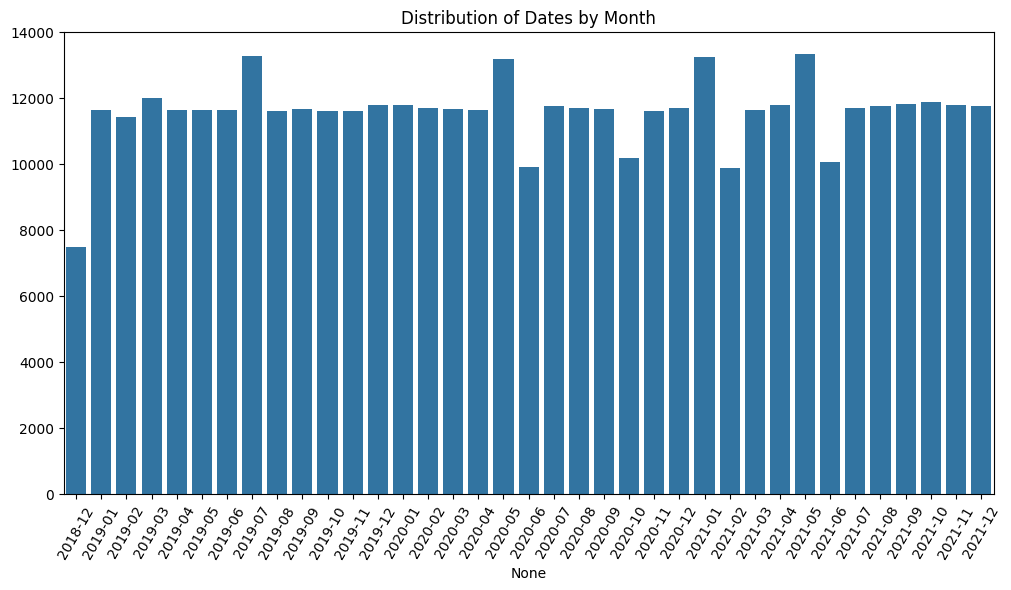

In [23]:
# plot the distribution of dates
DATES_PD = pd.to_datetime(DATES)

DATES_series = pd.Series(DATES_PD)

DATES_grouped = DATES_series.dt.to_period("M").value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=DATES_grouped.index.astype(str), y=DATES_grouped.values)
plt.xticks(rotation=60)

plt.title('Distribution of Dates by Month')
plt.show()

### Pixel Distribution

Image Index: 226630


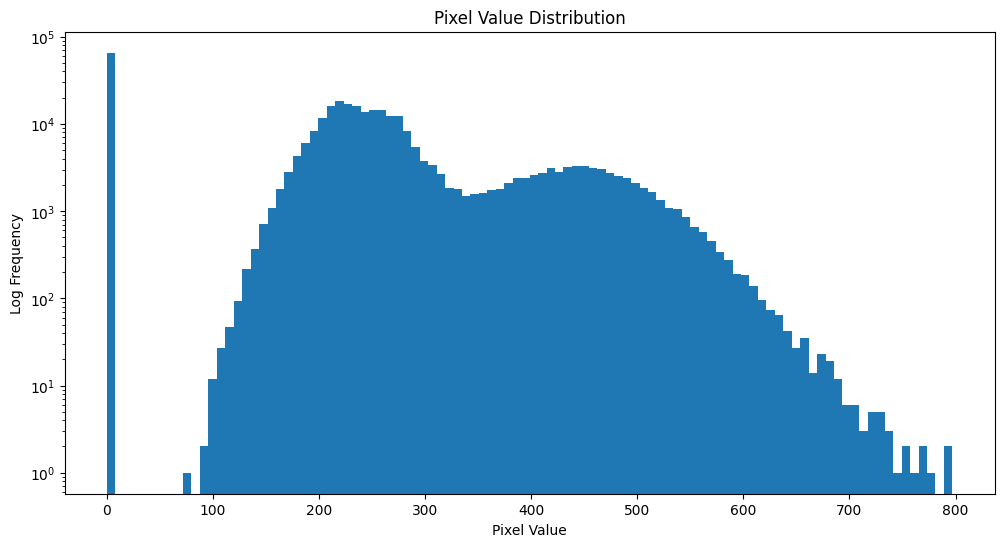

In [41]:
# select a random image and plot the magnitude of pixel values

idx = random.randint(0, len(DATES) - 1)
print("Image Index:", idx)
image = get_image(idx)


plt.figure(figsize=(12, 6))
plt.hist(image.flatten(), bins=100, log=True)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Log Frequency')
plt.show()


# Selecting Valid Data

## Criterion:
- CV2 algorithm is used to calculate the cloud coverage, and the threshold is set to <20%.
- QA60 mask is used to filter out the cloudy pixels, and the threshold is set to <50%.
- RGB mean of non-cloudy pixels evaluated from CV2 algorithm is used to filter out nighttime/low-light images, and the threshold is set to >0.1 (RGB range 0-1).

### Cloud Detection Helper Functions
- detect_clouds_qa60 - Calculates the cloud coverage given the QA60 band
- cv2_cloud_mask - Calculates cloud mask given RGB image using CV2

In [9]:
def detect_clouds_qa60(qa60_band):
    """
    Detects clouds in a QA60 band using bitmasks.
    
    Parameters:
    qa60_band (numpy.ndarray): 2D NumPy array representing the QA60 band.
    
    Returns:
    float: Percentage of the image covered by clouds.
    """
    # Define the bitmasks for clouds and cirrus
    cloud_bitmask = 1 << 10
    cirrus_bitmask = 1 << 11
    
    # Apply the bitmasks to detect clouds and cirrus
    cloud_mask = (qa60_band & cloud_bitmask) != 0
    cirrus_mask = (qa60_band & cirrus_bitmask) != 0
    
    # Combine the masks
    combined_mask = np.logical_or(cloud_mask, cirrus_mask)
    
    # Calculate the percentage of cloud cover
    cloud_pixels = np.sum(combined_mask)
    total_pixels = qa60_band.size
    cloud_coverage = (cloud_pixels / total_pixels) * 100
    
    return cloud_coverage

def cv2_cloud_mask(image):
    """
    Detects clouds in a Sentinel-2 image using OpenCV.
    
    Parameters:
    image (numpy.ndarray): 3D NumPy array representing the Sentinel-2 image with bands in the order [B2, B3, B4, B8, B8A, B11, B12].
    
    Returns:
    numpy.ndarray: 2D NumPy array representing the cloud mask.
    """
    # Convert the image to 8-bit unsigned integer format
    image_8bit = (image * 255).astype(np.uint8)
    
    # Convert the image to the BGR color space
    image_bgr = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2BGR)
    
    # Convert the image to the LAB color space
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab)
    
    # Split the LAB image into its components
    L, A, B = cv2.split(image_lab)
    
    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    L_clahe = clahe.apply(L)
    
    # Merge the CLAHE-enhanced L channel with the original A and B channels
    image_clahe = cv2.merge([L_clahe, A, B])
    
    # Convert the image back to the RGB color space
    image_rgb_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_Lab2RGB)
    
    # Convert the image to the HSV color space
    image_hsv = cv2.cvtColor(image_rgb_clahe, cv2.COLOR_RGB2HSV)
    
    # Threshold the image to get a binary mask of clouds
    lower = np.array([0, 0, 0])
    upper = np.array([180, 40, 255])
    cloud_mask = cv2.inRange(image_hsv, lower, upper)
    
    return cloud_mask

### Calculate & Save
- (i) QA60 Estimated Cloud Coverage 
- (ii) RGB Mean (CV2 Cloud Mask Removed) 
- (iii) CV2 Estimated Cloud Coverage

In [10]:
sent2_meta = []
if 'sent2_metadata.npy' in os.listdir(cwd):
    sent2_meta = np.load('sent2_metadata.npy', allow_pickle=True).tolist()
    print('Loaded sent2_meta:', len(sent2_meta))

def cloud_coverage(i):
    image = get_image(i)[1:4][::-1].squeeze().transpose(1, 2, 0)

    # clip bottom and top 5% of pixel values to remove outliers and normalize
    percentile = np.percentile(image, [5, 95])
    image = np.clip(image, percentile[0], percentile[1])
    image = (image - percentile[0]) / (percentile[1] - percentile[0])

    cloud_mask_cv2 = cv2_cloud_mask(image)/255
    cv2_cloud_percentage = np.sum(cloud_mask_cv2) / cloud_mask_cv2.size * 100

    # find average pixel values excluding clouds
    tmp = np.mean(image, axis=-1)
    tmp = tmp - cloud_mask_cv2
    tmp[tmp < 0] = 0
    rgb_mean = tmp.sum() / np.sum(cloud_mask_cv2 == 0)
    

    mask = get_image(i)[4]
    return (detect_clouds_qa60(mask), rgb_mean, cv2_cloud_percentage)

num_processes = mp.cpu_count()
print('Number of processes:', num_processes)
pool = mp.Pool(processes=num_processes)
args = [(i) for i in range(len(DATES)) if i >= len(sent2_meta)]

for cloud in tqdm(pool.imap(cloud_coverage, args), total=len(args)):
    sent2_meta.append(cloud)

pool.close()
pool.join()

print(len(args), len(sent2_meta))

sent2_meta = np.array(sent2_meta)
np_metadata(sent2_meta, 'Cloud Coverage')
# save the cloud coverage list
np.save('sent2_metadata.npy', sent2_meta)

Loaded sent2_meta: 427813
Number of processes: 12


0it [00:00, ?it/s]


0 427813

Name: Cloud Coverage
	Shape: (427813, 3)
	Size: 1283439
	Dimensions: 2
	Dtype: float64
	Memory Usage: 10267512 bytes
	MIN: nan
	MAX: nan
	Preview: [[6.86676025e+01 5.00295298e-01 1.60797119e+01]
 [1.03637695e+01 1.79143161e-01 9.96551514e+00]
 [1.00000000e+02 5.93778084e-01 7.58972168e+00]
 [4.41894531e+00 3.29876551e-01 4.42962646e+00]
 [1.00000000e+02 4.74601415e-01 7.47680664e+00]
 [1.00000000e+02 2.71089476e-01 6.57318115e+01]
 [4.56848145e+00 8.89749199e-02 2.67303467e+01]
 [9.71786499e+01 9.91734833e-02 4.86434937e+01]
 [1.00000000e+02 4.39548055e-01 2.25372314e+00]
 [1.00000000e+02 4.71113071e-01 0.00000000e+00]]



### Define Tolerance Levels

In [11]:
QA60_tolerance = 50
BRIGHTNESS_tolerance = 0.1
CV2_CLOUD_tolerance = 20

# Threshold CV2 tolerance for viewing sample data (CV2_CLOUD_VIEWING_tolerance, CV2_CLOUD_tolerance]
CV2_CLOUD_VIEWING_tolerance = -1

### Determine data availability at different tolerance levels


Name: Cloud Coverage
	Shape: (427813,)
	Size: 427813
	Dimensions: 1
	Dtype: float64
	Memory Usage: 3422504 bytes
	MIN: 0.0
	MAX: 100.0
	Preview: [ 68.66760254  10.36376953 100.           4.41894531 100.
 100.           4.56848145  97.1786499  100.         100.        ]



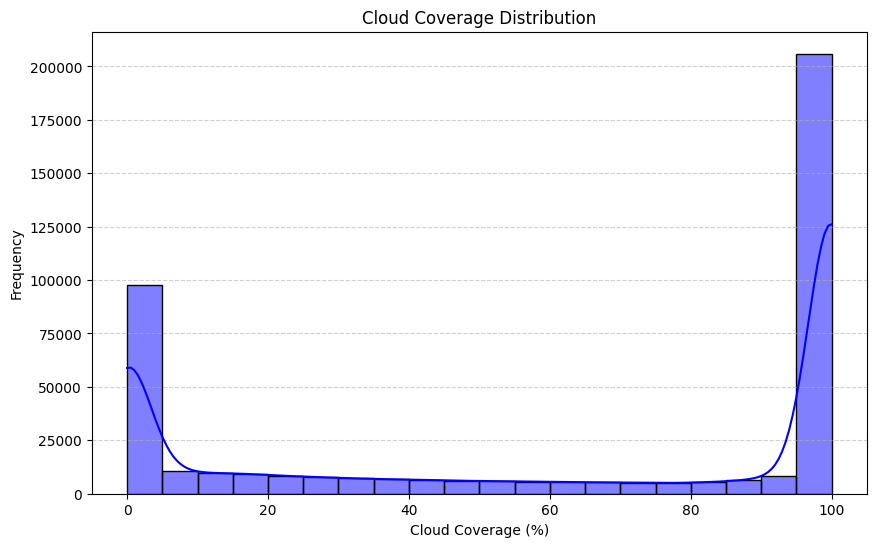

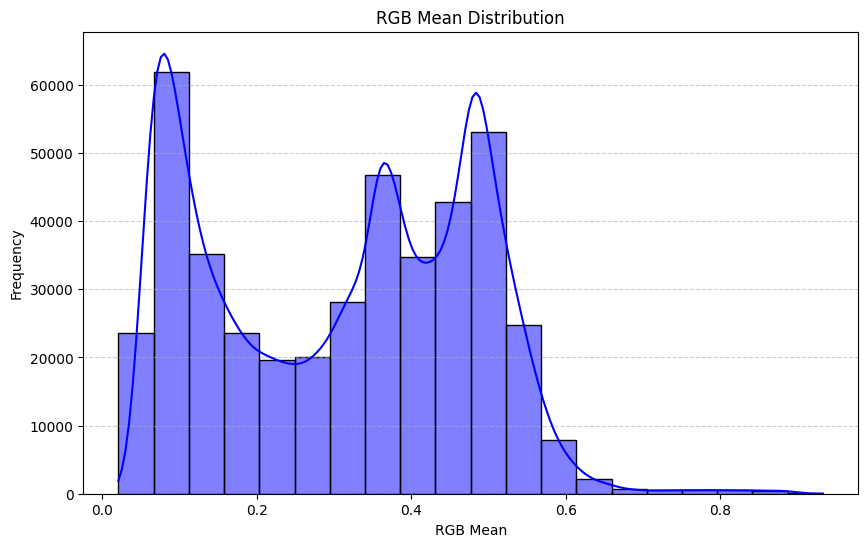

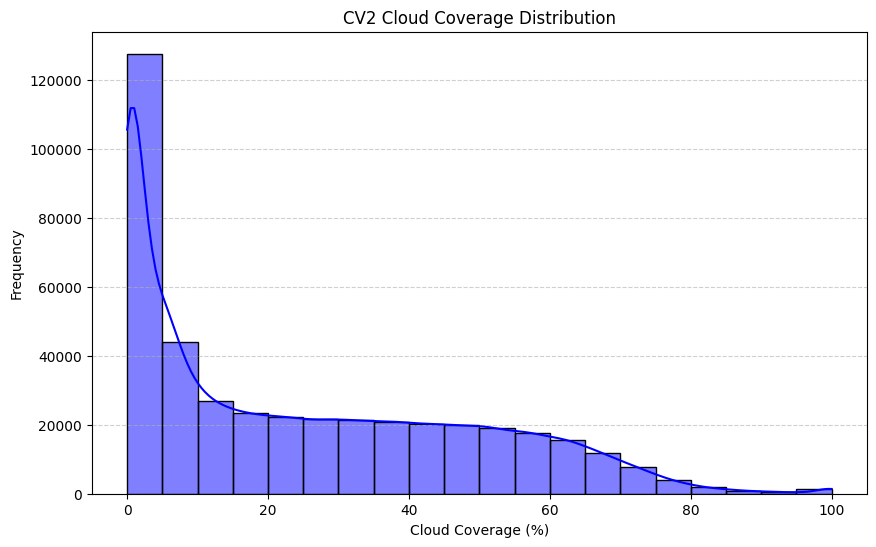

Number of processes: 12


100%|██████████| 121/121 [00:00<00:00, 500503.73it/s]


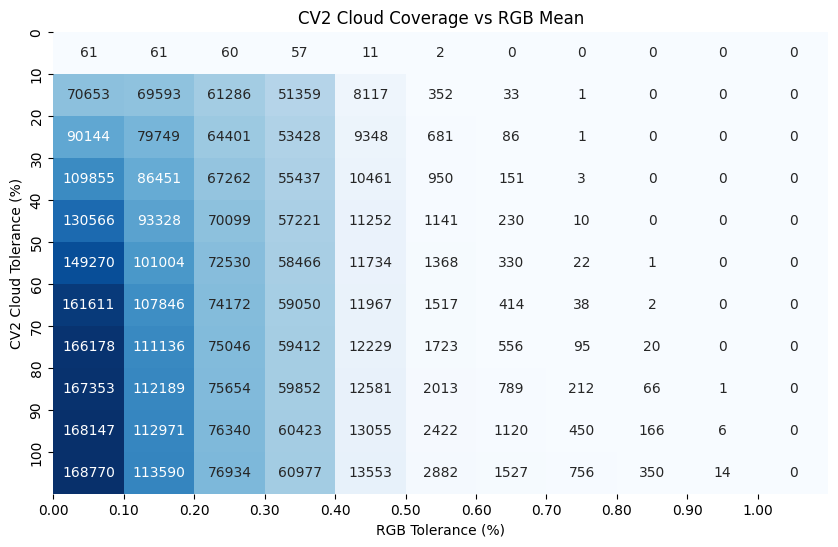

In [12]:
# Load the cloud coverage list
sent2_meta = np.load('sent2_metadata.npy').T
cloud_coverage_list, rgb_mean, cv2_cloud_coverage_list = sent2_meta
np_metadata(cloud_coverage_list, 'Cloud Coverage')

# Plot the cloud coverage distribution
plt.figure(figsize=(10, 6))
sns.histplot(cloud_coverage_list, bins=20, kde=True, color='blue')
plt.title('Cloud Coverage Distribution')
plt.xlabel('Cloud Coverage (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Plot the rgb mean distribution
plt.figure(figsize=(10, 6))
sns.histplot(rgb_mean, bins=20, kde=True, color='blue')
plt.title('RGB Mean Distribution')
plt.xlabel('RGB Mean')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Plot the cv2 cloud coverage distribution
plt.figure(figsize=(10, 6))
sns.histplot(cv2_cloud_coverage_list, bins=20, kde=True, color='blue')
plt.title('CV2 Cloud Coverage Distribution')
plt.xlabel('Cloud Coverage (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

TABLE = np.zeros((11, 11), dtype=int)
tmp_qa60_tolerance = 50

def CV2_vs_RGB(cloud_tolerance, rgb_tolerance):
        cnt = 0
        for i in range(len(cv2_cloud_coverage_list)):
            if cv2_cloud_coverage_list[i] <= cloud_tolerance and rgb_mean[i] >= rgb_tolerance * 0.1 and cloud_coverage_list[i] <= tmp_qa60_tolerance:
                cnt += 1
        return (cloud_tolerance, rgb_tolerance, cnt)

num_processes = mp.cpu_count()
print('Number of processes:', num_processes)
pool = mp.Pool(processes=num_processes)
args = [(cloud_tolerance, rgb_tolerance) for cloud_tolerance in range(0, 101, 10) for rgb_tolerance in range(0, 11, 1)]
for outputs in tqdm(pool.starmap(CV2_vs_RGB, args), total=len(args)):
    TABLE[outputs[0]//10][outputs[1]] = outputs[2]
pool.close()
pool.join()

# plot the table
plt.figure(figsize=(10, 6))
sns.heatmap(TABLE, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CV2 Cloud Coverage vs RGB Mean')
plt.xlabel('RGB Tolerance (%)')
plt.ylabel('CV2 Cloud Tolerance (%)')
plt.xticks(ticks=np.arange(11), labels=[f'{i*0.1:.2f}' for i in range(0, 11, 1)])
plt.yticks(ticks=np.arange(11), labels=[str(i) for i in range(0, 101, 10)])
plt.show() 

### Save some valid data

In [13]:
def save_image(index):

    # Load the image & normalize
    image = get_image(index).squeeze()[1:4][::-1].transpose(1, 2, 0)
    percentage = np.percentile(image, [5, 95])
    image = np.clip(image, percentage[0], percentage[1])
    image = (image - percentage[0]) / (percentage[1] - percentage[0])

    # Load the QA60 band cloud mask
    qa60 = get_image(index).squeeze()[4]
    qa60 = np.stack(3*[qa60/2048.], axis=-1)

    # Create cv2 cloud mask
    cloud_mask = cv2_cloud_mask(image)
    cv2_cloud_percentage = np.sum(cloud_mask/256) / cloud_mask.size * 100
    if cv2_cloud_percentage <= CV2_CLOUD_VIEWING_tolerance:
        return

    # Create fig for plotting image and QA60 and cv2 cloud mask
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('RGB Image')
    plt.subplot(1, 3, 2)
    plt.imshow((qa60), cmap='gray')
    plt.axis('off')
    plt.title('QA60 Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(cloud_mask, cmap='gray')
    plt.axis('off')
    plt.title('CV2 Mask')
    plt.close(fig)
    fig.savefig(f'pngs/sentinel2_valid_png_sample/{index}_{sent2_meta[0][index]:.2f}_{sent2_meta[1][index]:.3f}_{cv2_cloud_percentage:.3f}.png')

num_processes = mp.cpu_count()
print('Number of processes:', mp)
pool = mp.Pool(processes=num_processes)
args = [(i) for i in range(len(sent2_meta[0])) if (sent2_meta[0][i] <= QA60_tolerance and sent2_meta[1][i] >= BRIGHTNESS_tolerance and sent2_meta[2][i] <= CV2_CLOUD_tolerance)]
print('Number of images:', len(args))
args = random.sample(args, 1000)
#for _ in tqdm(pool.imap(save_image, args), total=len(args)):
#    pass
pool.close()
pool.join()

Number of processes: <module 'multiprocessing' from '/home/sarthakj/anaconda3/envs/multiearth/lib/python3.12/multiprocessing/__init__.py'>
Number of images: 79749


100%|██████████| 1000/1000 [00:31<00:00, 32.02it/s]


### Save some invalid data

In [14]:
def save_image(index):

    # Load the image & normalize
    image = get_image(index).squeeze()[1:4][::-1].transpose(1, 2, 0)
    percentage = np.percentile(image, [5, 95])
    image = np.clip(image, percentage[0], percentage[1])
    image = (image - percentage[0]) / (percentage[1] - percentage[0])

    # Load the QA60 band cloud mask
    qa60 = get_image(index).squeeze()[4]
    qa60 = np.stack(3*[qa60/2048.], axis=-1)

    # Create cv2 cloud mask
    cloud_mask = cv2_cloud_mask(image)
    cv2_cloud_percentage = np.sum(cloud_mask/256) / cloud_mask.size * 100

    # Create fig for plotting image and QA60 and cv2 cloud mask
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('RGB Image')
    plt.subplot(1, 3, 2)
    plt.imshow((qa60), cmap='gray')
    plt.axis('off')
    plt.title('QA60 Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(cloud_mask, cmap='gray')
    plt.axis('off')
    plt.title('CV2 Mask')
    plt.close(fig)
    fig.savefig(f'pngs/sentinel2_invalid_png_sample/{index}_{sent2_meta[0][index]:.2f}_{sent2_meta[1][index]:.3f}_{cv2_cloud_percentage:.3f}.png')

num_processes = mp.cpu_count()
print('Number of processes:', mp)
pool = mp.Pool(processes=num_processes)
args = [i for i in range(len(sent2_meta[0])) if (sent2_meta[0][i] <= QA60_tolerance and sent2_meta[1][i] >= BRIGHTNESS_tolerance and sent2_meta[2][i] <= CV2_CLOUD_tolerance)]
tmp_dict = {arg:None for arg in args}
args = [(i) for i in range(len(sent2_meta[0])) if i not in tmp_dict]
print('Number of images:', len(args))
args = random.sample(args, 1000)
#for _ in tqdm(pool.imap(save_image, args), total=len(args)):
#    pass
pool.close()
pool.join()

Number of processes: <module 'multiprocessing' from '/home/sarthakj/anaconda3/envs/multiearth/lib/python3.12/multiprocessing/__init__.py'>
Number of images: 348064


 41%|████      | 412/1000 [00:14<00:23, 24.90it/s]/tmp/ipykernel_64288/3505757791.py:7: RuntimeWarning: invalid value encountered in divide
  image = (image - percentage[0]) / (percentage[1] - percentage[0])
/tmp/ipykernel_64288/2798169151.py:40: RuntimeWarning: invalid value encountered in cast
  image_8bit = (image * 255).astype(np.uint8)
 70%|██████▉   | 699/1000 [00:23<00:10, 29.88it/s]/tmp/ipykernel_64288/3505757791.py:7: RuntimeWarning: invalid value encountered in divide
  image = (image - percentage[0]) / (percentage[1] - percentage[0])
/tmp/ipykernel_64288/2798169151.py:40: RuntimeWarning: invalid value encountered in cast
  image_8bit = (image * 255).astype(np.uint8)
100%|██████████| 1000/1000 [00:33<00:00, 29.60it/s]


### Save Valid Indices

In [15]:
args = [i for i in range(len(sent2_meta[0])) if (sent2_meta[0][i] <= QA60_tolerance and sent2_meta[1][i] >= BRIGHTNESS_tolerance and sent2_meta[2][i] <= CV2_CLOUD_tolerance)]
args = np.array(args)
np_metadata(args, 'Valid Image Indexes')
np.save('sent2_valid_image_index.npy', args)



Name: Valid Image Indexes
	Shape: (79749,)
	Size: 79749
	Dimensions: 1
	Dtype: int64
	Memory Usage: 637992 bytes
	MIN: 1
	MAX: 427797
	Preview: [ 1  3 18 36 40 41 42 43 45 46]



# Analyze Valid Data

# Analyze Valid Data

## Helpful Functions

In [ ]:
# Images
def get_image(idx):
    Original_num_images = Original_sent2.variables['images'].shape[0]
    Additional_num_images = Additional_sent2.variables['images'].shape[0]
    if idx < Original_num_images:
        return np.array(Original_sent2.variables['images'][idx])
    else:
        idx -= Original_num_images
        img = np.array(Additional_sent2.variables['images'][idx])
        img = img[[Additional_DATA_BANDS_DICT[band] for band in DATA_BANDS]]
        return img
    
def normalize_image(image):
    percentile = np.percentile(image, [5, 95])
    image = np.clip(image, percentile[0], percentile[1])
    image = (image - percentile[0]) / (percentile[1] - percentile[0])
    return image

## Valid Metadata

### Organize Data


Name: Valid Image Indexes
	Shape: (79749,)
	Size: 79749
	Dimensions: 1
	Dtype: int64
	Memory Usage: 637992 bytes
	Num Unique Values: 79749
	MIN: 1
	MAX: 427797
	Preview: [ 1  3 18 36 40 41 42 43 45 46]


Name: Coordinates
	Shape: (79749, 2)
	Size: 159498
	Dimensions: 2
	Dtype: float64
	Memory Usage: 1275984 bytes
	Num Unique Values: 88
	MIN: -55.2
	MAX: -3.33
	Preview: [[ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]]


Name: Dates
	Shape: (79749,)
	Size: 79749
	Dimensions: 1
	Dtype: <U10
	Memory Usage: 3189960 bytes
	Num Unique Values: 334
	Preview: ['2018-12-18' '2018-12-28' '2019-03-13' '2019-06-11' '2019-07-01'
 '2019-07-06' '2019-07-11' '2019-07-16' '2019-07-26' '2019-07-31']


Name: Diffs
	Shape: (78048,)
	Size: 78048
	Dimensions: 1
	Dtype: int64
	Memory Usage: 624384 bytes
	Num Unique Values: 144
	MIN: 2
	MAX: 485
(2, 3598) (3, 3671) (5, 27586) (7, 648) (8, 9

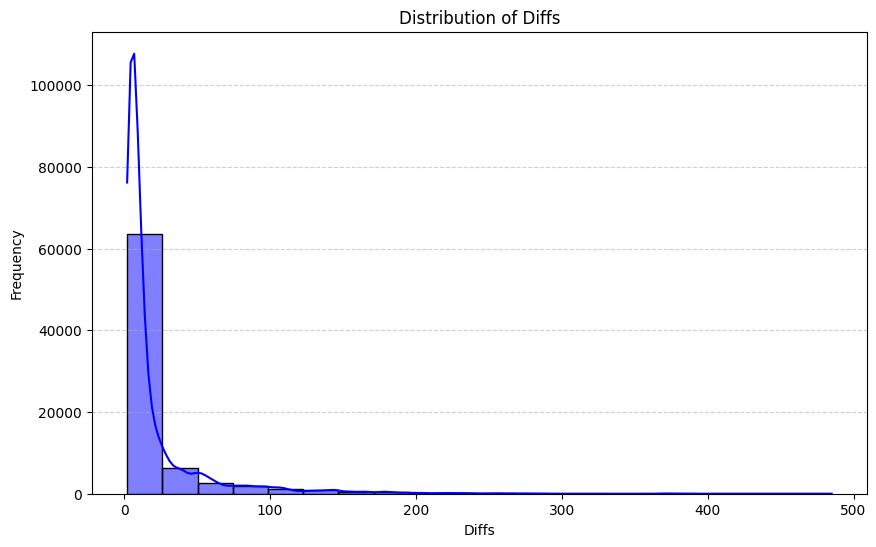

In [ ]:
# Get Valid Images Indexes
valid_image_indexes = np.load('sent2_valid_image_index.npy')
np_metadata(valid_image_indexes, 'Valid Image Indexes')

# Retrieve Metadata: COORDS, DATES, IMAGES
if COORDS.shape[0] == 2: COORDS = COORDS.T
if not COORDS.shape[0] == valid_image_indexes.shape[0]: COORDS = COORDS[valid_image_indexes]
if not DATES.shape[0] == valid_image_indexes.shape[0]: DATES = DATES[valid_image_indexes]
np_metadata(COORDS, 'Coordinates')
np_metadata(DATES, 'Dates')

DATES_NUM = [delta_from_date_date(date, date0='2018-12-13') for date in DATES]
COORD_DATE_DICT = defaultdict(list)
COORD_DATE_INDEX_DICT = {}
for i in range(len(COORDS)):
    COORD_DATE_DICT[tuple(COORDS[i])].append(DATES_NUM[i])
    COORD_DATE_INDEX_DICT[(tuple(COORDS[i]), DATES_NUM[i])] = valid_image_indexes[i]
diffs = []
DIFFS_TO_PAIRS = defaultdict(list)
for key in COORD_DATE_DICT.keys():
    dates = COORD_DATE_DICT[key]
    dates = sorted(dates)
    for i in range(1, len(dates)):
        diffs.append(dates[i] - dates[i-1])
        DIFFS_TO_PAIRS[dates[i] - dates[i-1]].append((COORD_DATE_INDEX_DICT[(key, dates[i-1])], COORD_DATE_INDEX_DICT[(key, dates[i])]))
diffs = np.array(diffs)
np_metadata(diffs, 'Diffs', True, True)

# plot distribution of diffs
plt.figure(figsize=(10, 6))
sns.histplot(diffs, bins=20, kde=True, color='blue')
plt.title('Distribution of Diffs')
plt.xlabel('Diffs')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Find Distribution of Frequencies for each Month


Name: Year-Month Frequency
	Shape: (37,)
	Size: 37
	Dimensions: 1
	Dtype: int64
	Memory Usage: 296 bytes
	Num Unique Values: 37
	MIN: 65
	MAX: 9361
(Value, Count): (65, 1) (84, 1) (122, 1) (241, 1) (254, 1) (298, 1) (349, 1) (355, 1) (370, 1) (372, 1) (465, 1) (482, 1) (516, 1) (628, 1) (680, 1) (771, 1) (783, 1) (837, 1) (895, 1) (1031, 1) (1045, 1) (1224, 1) (1502, 1) (1811, 1) (1895, 1) (2039, 1) (2328, 1) (3167, 1) (4257, 1) (4473, 1) (4926, 1) (4961, 1) (5491, 1) (5947, 1) (6736, 1) (8988, 1) (9361, 1) 	Preview: [ 65  84 122 241 254 298 349 355 370 372]



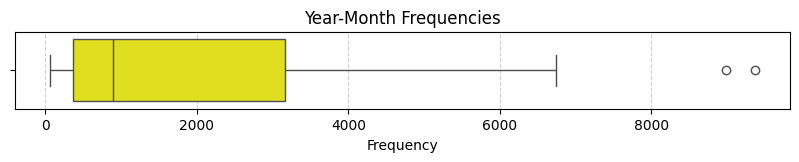

In [ ]:
DATE_YEAR_MONTH_DICT = defaultdict(int)
for date in DATES:
    DATE_YEAR_MONTH_DICT[date[:7]] += 1
values = np.array(sorted(list(DATE_YEAR_MONTH_DICT.values())))
np_metadata(values, 'Year-Month Frequency', True, True)

# plot distribution of dates on a horizontal boxplot
plt.figure(figsize=(10, 1))
sns.boxplot(x=values, color='yellow')
plt.title('Year-Month Frequencies')
plt.xlabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

### Save Sample Paired Images

In [ ]:
time_diff = 30
def save_pair_plot(PAIR):
    # Create a new figure
    fig = plt.figure(figsize=(12, 6))
    
    # First subplot for the first image
    plt.subplot(1, 2, 1)
    image1 = get_image(PAIR[0]).squeeze()[1:4][::-1].transpose(1, 2, 0)
    plt.imshow(normalize_image(image1))
    plt.axis('off')
    plt.title('Image 1')
    
    # Second subplot for the second image
    plt.subplot(1, 2, 2)
    image2 = get_image(PAIR[1]).squeeze()[1:4][::-1].transpose(1, 2, 0)
    plt.imshow(normalize_image(image2))
    plt.axis('off')
    plt.title('Image 2')
    
    # Ensure the directory exists
    output_dir = 'pngs/sentinel2_time_diffs'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    fig.savefig(f'{output_dir}/{PAIR[0]}_{PAIR[1]}-{time_diff}.png')
    
    # Close the figure to prevent it from displaying
    plt.close(fig)

num_workers = mp.cpu_count()
print('Number of workers:', num_workers)
pool = mp.Pool(processes=num_workers)
args = [PAIR for PAIR in DIFFS_TO_PAIRS[time_diff]]
for _ in tqdm(pool.imap(save_pair_plot, args), total=len(args), desc='Saving Pair Plots'):
    pass
pool.close()
pool.join()

Number of workers: 12


Saving Pair Plots: 100%|██████████| 1471/1471 [00:48<00:00, 30.08it/s]


## Helpful Functions

In [16]:
# Images
def get_image(idx):
    Original_num_images = Original_sent2.variables['images'].shape[0]
    Additional_num_images = Additional_sent2.variables['images'].shape[0]
    if idx < Original_num_images:
        return np.array(Original_sent2.variables['images'][idx])
    else:
        idx -= Original_num_images
        img = np.array(Additional_sent2.variables['images'][idx])
        img = img[[Additional_DATA_BANDS_DICT[band] for band in DATA_BANDS]]
        return img
    
def normalize_image(image):
    percentile = np.percentile(image, [5, 95])
    image = np.clip(image, percentile[0], percentile[1])
    image = (image - percentile[0]) / (percentile[1] - percentile[0])
    return image

## Valid Metadata

### Organize Data


Name: Valid Image Indexes
	Shape: (79749,)
	Size: 79749
	Dimensions: 1
	Dtype: int64
	Memory Usage: 637992 bytes
	Num Unique Values: 79749
	MIN: 1
	MAX: 427797
	Preview: [ 1  3 18 36 40 41 42 43 45 46]


Name: Coordinates
	Shape: (79749, 2)
	Size: 159498
	Dimensions: 2
	Dtype: float64
	Memory Usage: 1275984 bytes
	Num Unique Values: 88
	MIN: -55.2
	MAX: -3.33
	Preview: [[ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]]


Name: Dates
	Shape: (79749,)
	Size: 79749
	Dimensions: 1
	Dtype: <U10
	Memory Usage: 3189960 bytes
	Num Unique Values: 334
	Preview: ['2018-12-18' '2018-12-28' '2019-03-13' '2019-06-11' '2019-07-01'
 '2019-07-06' '2019-07-11' '2019-07-16' '2019-07-26' '2019-07-31']


Name: Diffs
	Shape: (78048,)
	Size: 78048
	Dimensions: 1
	Dtype: int64
	Memory Usage: 624384 bytes
	Num Unique Values: 144
	MIN: 2
	MAX: 485
(2, 3598) (3, 3671) (5, 27586) (7, 648) (8, 9

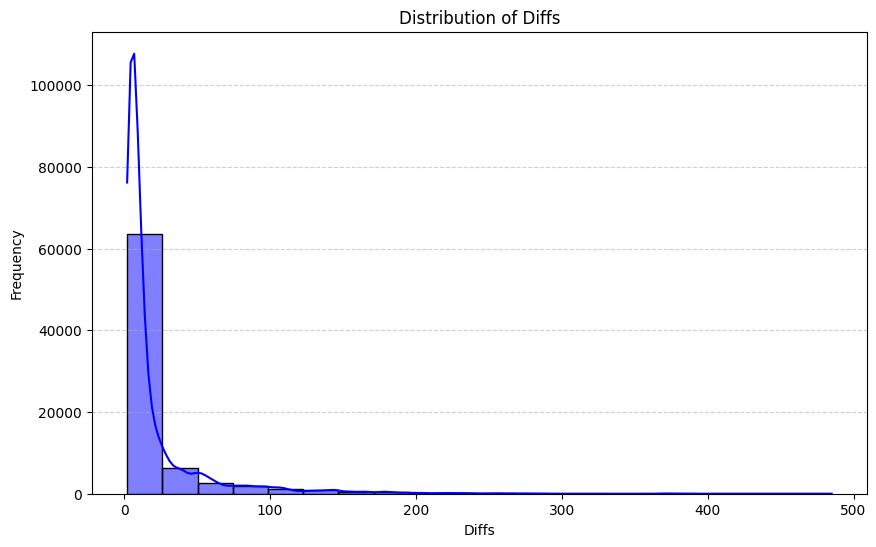

In [24]:
# Get Valid Images Indexes
valid_image_indexes = np.load('sent2_valid_image_index.npy')
np_metadata(valid_image_indexes, 'Valid Image Indexes')

# Retrieve Metadata: COORDS, DATES, IMAGES
if COORDS.shape[0] == 2: COORDS = COORDS.T
if not COORDS.shape[0] == valid_image_indexes.shape[0]: COORDS = COORDS[valid_image_indexes]
if not DATES.shape[0] == valid_image_indexes.shape[0]: DATES = DATES[valid_image_indexes]
np_metadata(COORDS, 'Coordinates')
np_metadata(DATES, 'Dates')

DATES_NUM = [delta_from_date_date(date, date0='2018-12-13') for date in DATES]
COORD_DATE_DICT = defaultdict(list)
COORD_DATE_INDEX_DICT = {}
for i in range(len(COORDS)):
    COORD_DATE_DICT[tuple(COORDS[i])].append(DATES_NUM[i])
    COORD_DATE_INDEX_DICT[(tuple(COORDS[i]), DATES_NUM[i])] = valid_image_indexes[i]
diffs = []
DIFFS_TO_PAIRS = defaultdict(list)
for key in COORD_DATE_DICT.keys():
    dates = COORD_DATE_DICT[key]
    dates = sorted(dates)
    for i in range(1, len(dates)):
        diffs.append(dates[i] - dates[i-1])
        DIFFS_TO_PAIRS[dates[i] - dates[i-1]].append((COORD_DATE_INDEX_DICT[(key, dates[i-1])], COORD_DATE_INDEX_DICT[(key, dates[i])]))
diffs = np.array(diffs)
np_metadata(diffs, 'Diffs', True, True)

# plot distribution of diffs
plt.figure(figsize=(10, 6))
sns.histplot(diffs, bins=20, kde=True, color='blue')
plt.title('Distribution of Diffs')
plt.xlabel('Diffs')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Find Distribution of Frequencies for each Month


Name: Year-Month Frequency
	Shape: (37,)
	Size: 37
	Dimensions: 1
	Dtype: int64
	Memory Usage: 296 bytes
	Num Unique Values: 37
	MIN: 65
	MAX: 9361
(Value, Count): (65, 1) (84, 1) (122, 1) (241, 1) (254, 1) (298, 1) (349, 1) (355, 1) (370, 1) (372, 1) (465, 1) (482, 1) (516, 1) (628, 1) (680, 1) (771, 1) (783, 1) (837, 1) (895, 1) (1031, 1) (1045, 1) (1224, 1) (1502, 1) (1811, 1) (1895, 1) (2039, 1) (2328, 1) (3167, 1) (4257, 1) (4473, 1) (4926, 1) (4961, 1) (5491, 1) (5947, 1) (6736, 1) (8988, 1) (9361, 1) 	Preview: [ 65  84 122 241 254 298 349 355 370 372]



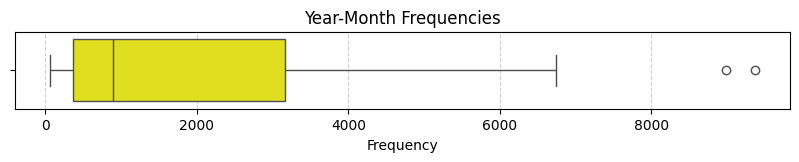

In [45]:
DATE_YEAR_MONTH_DICT = defaultdict(int)
for date in DATES:
    DATE_YEAR_MONTH_DICT[date[:7]] += 1
values = np.array(sorted(list(DATE_YEAR_MONTH_DICT.values())))
np_metadata(values, 'Year-Month Frequency', True, True)

# plot distribution of dates on a horizontal boxplot
plt.figure(figsize=(10, 1))
sns.boxplot(x=values, color='yellow')
plt.title('Year-Month Frequencies')
plt.xlabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

### Save Sample Paired Images

In [26]:
time_diff = 30
def save_pair_plot(PAIR):
    # Create a new figure
    fig = plt.figure(figsize=(12, 6))
    
    # First subplot for the first image
    plt.subplot(1, 2, 1)
    image1 = get_image(PAIR[0]).squeeze()[1:4][::-1].transpose(1, 2, 0)
    plt.imshow(normalize_image(image1))
    plt.axis('off')
    plt.title('Image 1')
    
    # Second subplot for the second image
    plt.subplot(1, 2, 2)
    image2 = get_image(PAIR[1]).squeeze()[1:4][::-1].transpose(1, 2, 0)
    plt.imshow(normalize_image(image2))
    plt.axis('off')
    plt.title('Image 2')
    
    # Ensure the directory exists
    output_dir = 'pngs/sentinel2_time_diffs'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    fig.savefig(f'{output_dir}/{PAIR[0]}_{PAIR[1]}-{time_diff}.png')
    
    # Close the figure to prevent it from displaying
    plt.close(fig)

num_workers = mp.cpu_count()
print('Number of workers:', num_workers)
pool = mp.Pool(processes=num_workers)
args = [PAIR for PAIR in DIFFS_TO_PAIRS[time_diff]]
for _ in tqdm(pool.imap(save_pair_plot, args), total=len(args), desc='Saving Pair Plots'):
    pass
pool.close()
pool.join()

Number of workers: 12


Saving Pair Plots: 100%|██████████| 1471/1471 [00:48<00:00, 30.08it/s]


# Environmental Prediction CSV Analysis

Index(['Longitude', 'Latitude', 'Date', 'Modality'], dtype='object')

Name: Dates
	Shape: (620,)
	Size: 620
	Dimensions: 1
	Dtype: datetime64[ns]
	Memory Usage: 4960 bytes
	Num Unique Values: 76
	MIN: 2019-01-12 00:00:00
	MAX: 2021-12-02 00:00:00
	Preview: DatetimeIndex(['2019-07-06', '2021-05-21', '2019-07-11', '2020-07-15',
               '2020-07-20', '2020-08-29', '2020-12-12', '2021-07-10',
               '2021-08-04', '2021-08-19'],
              dtype='datetime64[ns]', freq=None)

Modalities: ['Landsat-8_SR_B4' 'Sentinel-2_B9' 'Landsat-8_SR_B1' ... 'Landsat-8_SR_B2'
 'Sentinel-2_B4' 'Sentinel-1_VV']
Modality Count: defaultdict(<class 'int'>, {'Landsat-8': 913, 'Sentinel-2': 620, 'Sentinel-1': 467})


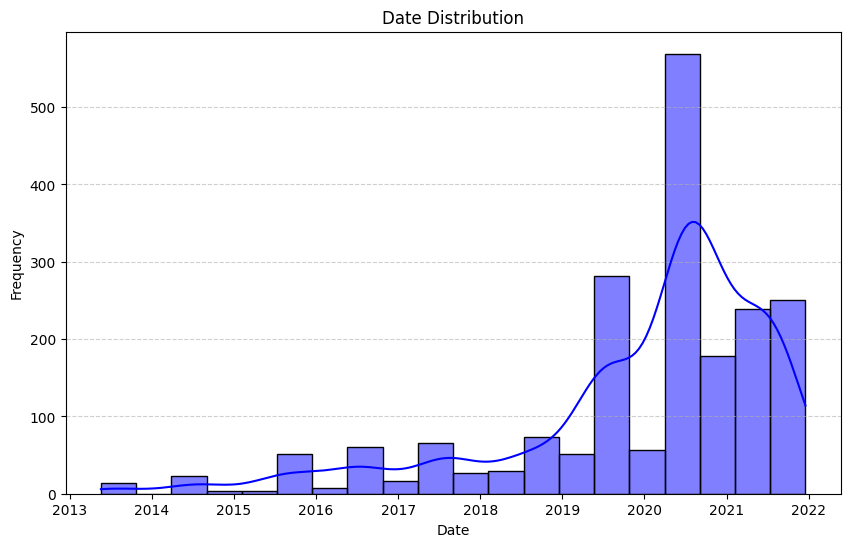

In [28]:
data_directory = data_path
DIR = sorted(os.listdir(data_directory))
DIR = [file for file in DIR if ('.csv' in file)]

env_pred_targets_file = 'prediction_targets.csv'
env_pred_targets = pd.read_csv(os.path.join(data_directory, env_pred_targets_file))
print(env_pred_targets.columns)

# NP Metadata on Dates if Sentinel-2 is in the Modality
dates = env_pred_targets['Date']
dates = [dates[i] for i in range(len(dates)) if 'Sentinel-2' in env_pred_targets['Modality'][i]]
dates = pd.to_datetime(dates, format='%Y_%m_%d')
np_metadata(dates, 'Dates')

# index column labeled Modality
modalities = env_pred_targets['Modality']
modalities = np.array(modalities)
print('Modalities:', modalities)

# Count each modality
MODALITY = defaultdict(int)
for modality in modalities:
    MODALITY[modality.split('_')[0]] += 1
print('Modality Count:', MODALITY)

# index columb labeled Date
dates = env_pred_targets['Date']
dates = pd.to_datetime(dates, format='%Y_%m_%d')

# Plot the date distribution
plt.figure(figsize=(10, 6))
sns.histplot(dates, bins=20, kde=True, color='blue')
plt.title('Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
